# 삼성 DS-KAIST AI Expert 프로그램
## Week 4: Transfer Learning

실습 일시: 2019년 7월 23일 (화), 13:30 - 17:30

담당 조교: 이한국 (hankook.lee@kaist.ac.kr)

# Section 0. Introduction

본 실습에서는 TensorFlow와 Keras 프레임워크를 이용하여, transfer learning에 관한 실습을 진행할 것입니다. transfer learning은 다른 학습된 network의 knowledge를을 새로운 network를 학습할 때 활용하는 방법으로, 각각의 방법에 대해 어떤 효과가 생기는지 알아볼 예정입니다.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

### Hyperparamters

아래는 이번 실습에서 사용할 hyperparameter들을 사전 정의해 둔 것입니다.

In [3]:
batch_size = 128
steps_per_epoch = 300
num_epochs = 10

# Section 1. Load Dataset (CIFAR-10, CIFAR-100)

이번 실습에서 사용할 dataset은 CIFAR-10과 CIFAR-100 입니다. 각 dataset은 총 50000개의 training image를 가지고 있고, 10000개의 test image를 가지고 있습니다. 또한, CIFAR-10의 이미지는 10개의 class중 하나에 속하고, CIFAR-100의 이미지는 100개의 class중 하나에 속하게 됩니다.

In [4]:
cifar10 = tf.keras.datasets.cifar10
cifar100 = tf.keras.datasets.cifar100

In [5]:
(x_train_c10, y_train_c10), (x_test_c10, y_test_c10) = cifar10.load_data()
(x_train_c100, y_train_c100), (x_test_c100, y_test_c100) = cifar100.load_data()

In [6]:
print('CIFAR-10 ------')
print('트레이닝 샘플 수: %d' % x_train_c10.shape[0])
print('이미지 크기: %d x %d x %d' % (x_train_c10.shape[1], x_train_c10.shape[2], x_train_c10.shape[3]))
print('트레이닝 데이터 크기: %d x %d x %d x %d' % (*x_train_c10.shape, ))
print('')
print('CIFAR-100 ------')
print('트레이닝 샘플 수: %d' % x_train_c100.shape[0])
print('이미지 크기: %d x %d x %d' % (x_train_c100.shape[1], x_train_c100.shape[2], x_train_c100.shape[3]))
print('트레이닝 데이터 크기: %d x %d x %d x %d' % (*x_train_c100.shape, ))

CIFAR-10 ------
트레이닝 샘플 수: 50000
이미지 크기: 32 x 32 x 3
트레이닝 데이터 크기: 50000 x 32 x 32 x 3

CIFAR-100 ------
트레이닝 샘플 수: 50000
이미지 크기: 32 x 32 x 3
트레이닝 데이터 크기: 50000 x 32 x 32 x 3


### Preprocessing Data
Image의 pixel 의 값은 (R, G, B) 형태로 표현되고, 각 channel (R/G/B) 마다 [0, 1, 2, ..., 255] 의 정수 값을 가집니다. 일반적으로 neural network를 학습할 때에는 normalized 되어있는 값을 input으로 사용하는 것이 좋습니다. 따라서, 각 image 값들을 [0, 1/255, ..., 1.0] 의 실수 값으로 치환해줍니다.
Image의 label 은 [0, 1, 2, ..., 9] 의 값을 가집니다. 이러한 label 정보는 일반적으로 one-hot encoding으로 바꿔주어 사용합니다. one-hot encoding을 하게 되면 label 0은 [1, 0, 0, ..., 0], label 1은 [0, 1, 0, ..., 0], 그리고 label 9는 [0, 0, 0, ..., 1]으로 바뀌게 됩니다.

In [7]:
x_train_c10 = x_train_c10 / 255.0
x_test_c10 = x_test_c10 / 255.0

y_train_c10 = tf.keras.utils.to_categorical(y_train_c10, 10)
y_test_c10 = tf.keras.utils.to_categorical(y_test_c10, 10)

In [8]:
x_train_c100 = x_train_c100 / 255.0
x_test_c100 = x_test_c100 / 255.0

y_train_c100 = tf.keras.utils.to_categorical(y_train_c100, 100)
y_test_c100 = tf.keras.utils.to_categorical(y_test_c100, 100)

### Data Generator

`ImageDataGenerator`는 Keras에 있는 API 중 하나로, data augmentation (좌우 반전 등) 을 손쉽게 할 수 있습니다. 가능한 data augmentation 방법들은 내용은 https://keras.io/preprocessing/image/ 에서 확인하실 수 있습니다. 이번 실습에서는 일반적으로 CIFAR dataset에서 사용하는 random 상하좌우 shift와 좌우 반전을 사용할 것입니다.

In [9]:
datagen_c10 = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=5,
    height_shift_range=5,
    fill_mode='constant',
    horizontal_flip=True).flow(x_train_c10, y_train_c10, batch_size=batch_size)

In [10]:
datagen_c100 = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=5,
    height_shift_range=5,
    fill_mode='constant',
    horizontal_flip=True).flow(x_train_c100, y_train_c100, batch_size=batch_size)

### Plotting Images

아래의 script를 이용하여 각 데이터셋에 어떤 이미지들이 들어있는지 확인할 수 있습니다.

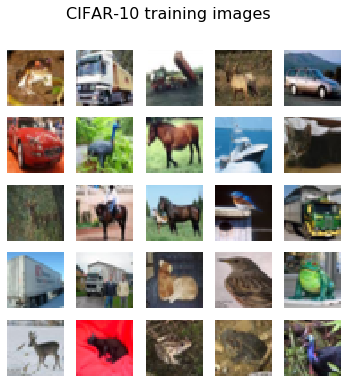

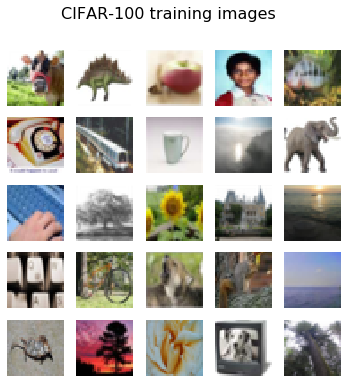

In [11]:
plt.figure(figsize=(6,6))
plt.suptitle('CIFAR-10 training images', fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train_c10[i])
    plt.axis('off')
    
plt.figure(figsize=(6,6))
plt.suptitle('CIFAR-100 training images', fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train_c100[i])
    plt.axis('off')

# Section 2. Transfer Learning using Keras

이번 실습에서는 간단한 6-layer CNN을 사용할 것입니다.

`build_conv_block`은 convolutional layer와, batch normalization layer, 그리고 relu activation으로 구성된 하나의 convolutional block입니다.

In [12]:
def build_conv_block(inputs, num_channels):
    inputs = Conv2D(num_channels, (3, 3), padding='same')(inputs)
    inputs = BatchNormalization()(inputs)
    inputs = Activation('relu')(inputs)
    return inputs

`build_network`는 하나의 CNN을 만드는 역할을 합니다. 이 함수는 `inputs`, `num_classes`, `base_width` 세 개의 인자를 받습니다.
- `inputs`: model의 input shape을 나타내는 역할을 합니다.
- `num_classes`: 최종 output dimension을 나타냅니다. classification 문제의 경우, label의 종류의 수와 같습니다.
- `base_width`: network의 width를 나타내는 역할을 합니다. teacher model로 wide한 모델을 사용할 것이고, student 모델로는 thin한 모델을 사용할 예정입니다.

`build_network`는 총 5개의 tensor를 return합니다.
- `outputs`: network의 최종 출력값으로, softmax activation이 이루어진 값입니다.
- `logits`: softmax activation을 하기 직전의 값입니다. 이 값은 knowledge distillation method에서 사용될 예정입니다. 
- `x1`, `x2`, `x3`: pooling 직전의 hidden feature map을 나타냅니다. 이 hidden feature map들은 추후에 attention transfer를 할 때 쓰일 예정입니다.

In [13]:
def build_network(inputs, num_classes=10, base_width=16):
    x1 = build_conv_block(inputs, base_width)
    x1 = build_conv_block(x1, base_width)
    
    x2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x1)
    x2 = build_conv_block(x2, base_width*2)
    x2 = build_conv_block(x2, base_width*2)

    x3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x2)
    x3 = build_conv_block(x3, base_width*4)
    x3 = build_conv_block(x3, base_width*4)

    logits = GlobalAveragePooling2D()(x3)
    logits = Dense(num_classes)(logits)
    outputs = Activation('softmax')(logits)
    
    return outputs, logits, x1, x2, x3

In [14]:
inputs = Input(shape=(32, 32, 3))

## Define Teacher Model

먼저, `base_width=16`인 teacher network를 정의하고, initial weights를 저장합니다.

In [15]:
outputs_t, logits_t, x1_t, x2_t, x3_t = build_network(inputs, base_width=16)
teacher = tf.keras.models.Model(inputs=inputs, outputs=outputs_t, name='teacher')
teacher.summary()

W0729 22:47:47.623306 13384 deprecation.py:506] From C:\Users\home0194\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0   

In [16]:
teacher.save_weights('teacher_init.h5')

## Define Student Model

이제 `base_width=8`인 student network를 정의하고, initial weights를 저장합니다. Transfer learning을 이용하여 student network의 성능을 올려볼 예정입니다.

In [17]:
outputs_s, logits_s, x1_s, x2_s, x3_s = build_network(inputs, base_width=8)
student = tf.keras.models.Model(inputs=inputs, outputs=outputs_s, name='student')
student.summary()

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 8)         0   

In [18]:
student.save_weights('student_init.h5')

아래 함수 `plot_history`는 training curve를 시각화하는 함수입니다. 학습 후 성능이 어떻게 변화하는지 관측해볼 것입니다.

In [19]:
def plot_history(history):
    epochs = len(history.history['loss'])
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(range(epochs), history.history['loss'], 'r')
    plt.plot(range(epochs), history.history['val_loss'], 'b')
    plt.legend(['train', 'val'])

    plt.subplot(1, 2, 2)
    plt.title('accuracy')
    plt.plot(range(epochs), history.history['acc'], 'r--')
    plt.plot(range(epochs), history.history['val_acc'], 'b--')    
    plt.legend(['train', 'val'])

    print('최대 도달 성능: %.2f%%' % (max(history.history['val_acc'])*100,))

## Train Teacher Network

Transfer learning을 하기에 앞서, Keras의 `compile` 함수를 이용하여 optimizer, loss, metric을 선언해줍니다.

In [20]:
teacher.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

그리고 Model의 `fit_generator`를 사용하여 네트워크를 학습해줍니다. 여기서 `generator`는 위에서 선언한 data augmentation이 된 dataset으로 생각할 수 있습니다. `steps_per_epoch`은 한 epoch마다 iteration 수를, `epochs`는 총 epoch을 나타냅니다.

In [21]:
history = teacher.fit_generator(datagen_c10,
                                steps_per_epoch=steps_per_epoch,
                                epochs=num_epochs,
                                validation_data=(x_test_c10, y_test_c10))

Epoch 1/10
300/300 [==============================] - 228s 760ms/step - loss: 1.4643 - acc: 0.4726 - val_loss: 2.6527 - val_acc: 0.2062
Epoch 2/10
300/300 [==============================] - 264s 881ms/step - loss: 1.1179 - acc: 0.5998 - val_loss: 1.3974 - val_acc: 0.5446
Epoch 3/10
300/300 [==============================] - 266s 885ms/step - loss: 0.9977 - acc: 0.6438 - val_loss: 0.9955 - val_acc: 0.6472
Epoch 4/10
300/300 [==============================] - 269s 896ms/step - loss: 0.9211 - acc: 0.6707 - val_loss: 1.4123 - val_acc: 0.5629
Epoch 5/10
300/300 [==============================] - 267s 890ms/step - loss: 0.8510 - acc: 0.7000 - val_loss: 1.0599 - val_acc: 0.6303
Epoch 6/10
300/300 [==============================] - 263s 877ms/step - loss: 0.8162 - acc: 0.7127 - val_loss: 1.0671 - val_acc: 0.6496
Epoch 7/10
300/300 [==============================] - 264s 879ms/step - loss: 0.7709 - acc: 0.7303 - val_loss: 0.9580 - val_acc: 0.6724
Epoch 8/10
300/300 [============================

위에서 선언한 `plot_history` 함수를 이용하여 학습이 어떻게 되었는지 확인해봅니다.

최대 도달 성능: 71.79%


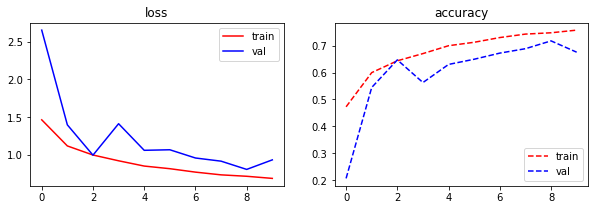

In [22]:
plot_history(history)

teacher는 이제 더 이상 학습하지 않고, transfer learning에만 쓰일 예정이므로, 학습이 되지 않도록 `trainable` 을 `False`로 만들어줍니다.

In [23]:
teacher.trainable = False

## Q1. Transfer Learning 없이, Student 모델 학습해보기 (20 min)

In [24]:
# student model을 초기화해줍니다.
student.load_weights('student_init.h5')
student.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

이전 실습과 위의 코드를 바탕으로, `student` 모델을 학습해보세요. 그 후, `plot_history`를 이용하여 학습이 어떻게 되었는지 확인해보세요.

In [25]:
# Q1: train student
history = student.fit_generator(datagen_c10,
                                steps_per_epoch=steps_per_epoch,
                                epochs=num_epochs,
                                validation_data=(x_test_c10, y_test_c10))

Epoch 1/10
300/300 [==============================] - 189s 630ms/step - loss: 1.6700 - acc: 0.3989 - val_loss: 2.0746 - val_acc: 0.2593
Epoch 2/10
300/300 [==============================] - 182s 607ms/step - loss: 1.3440 - acc: 0.5154 - val_loss: 1.7469 - val_acc: 0.4174
Epoch 3/10
300/300 [==============================] - 171s 570ms/step - loss: 1.2195 - acc: 0.5631 - val_loss: 1.5821 - val_acc: 0.4625
Epoch 4/10
300/300 [==============================] - 170s 566ms/step - loss: 1.1352 - acc: 0.5909 - val_loss: 1.3176 - val_acc: 0.5481
Epoch 5/10
300/300 [==============================] - 166s 553ms/step - loss: 1.0853 - acc: 0.6110 - val_loss: 1.1689 - val_acc: 0.5831
Epoch 6/10
300/300 [==============================] - 167s 556ms/step - loss: 1.0534 - acc: 0.6191 - val_loss: 1.0800 - val_acc: 0.6156
Epoch 7/10
300/300 [==============================] - 168s 560ms/step - loss: 1.0223 - acc: 0.6358 - val_loss: 1.1971 - val_acc: 0.5810
Epoch 8/10
300/300 [============================

최대 도달 성능: 61.56%


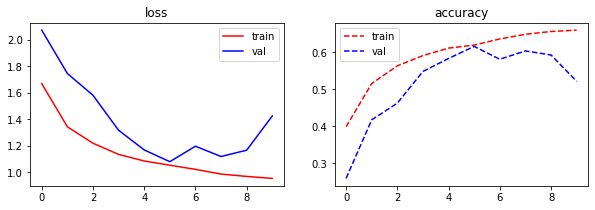

In [26]:
# Q1: training curve visualization
plot_history(history)

## Q2: Knowledge Distillation을 이용하여 모델의 성능을 개선시키기 (40 min)

$l_t$, $l_s$를 teacher/student의 logit 값이고, $T$를 temperature라고 할 때, knowledge distllation의 식은 아래와 같습니다.

\begin{align}
p_t & =\text{softmax}(l_t/T) \\
p_s &=\text{softmax}(l_s/T) \\
\mathcal{L}_\text{KD} (l_t, l_s) & =\text{KL}(p_t || p_s) = \text{constant} - \sum_i p_t^{(i)} \log p_s^{(i)}
\end{align}

아래의 함수(링크 참조)를 이용하여, 위의 knowledge distillation loss $\mathcal{L}_\text{KD} (a_t, a_s)$를 구현하세요.
- [`tf.nn.softmax`](https://www.tensorflow.org/api_docs/python/tf/nn/log_softmax) : $p_t$를 구할 때 사용합니다.
- [`tf.nn.log_softmax`](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) : $\log p_s$를 구할 때 사용합니다.
- [`tf.math.reduce_sum`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum) : $\sum_i$ 할 때 사용합니다. (`axis=1`)
- [`tf.math.reduce_mean`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean) : batch의 모든 sample에 대해서 average를 취할 때 사용합니다.

In [27]:
def knowledge_distillation(l_t, l_s, T):
    # Q2: knowledge distillation loss 구현
    pt = tf.nn.softmax(l_t/T)
    ps = tf.nn.log_softmax(l_s/T)
    loss = -tf.math.reduce_sum(pt*ps, axis=1)
    print(loss)
    loss = tf.math.reduce_mean(loss)
    print(loss)
    return loss

In [28]:
knowledge_distillation(logits_t, logits_s, 2) # debug KKH

Tensor("Neg:0", shape=(?,), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)


<tf.Tensor 'Mean:0' shape=() dtype=float32>

이제, CNN을 학습하기 위한 loss function을 정의합니다. 아래에서 `kd_weight` 와 `T`는 hyperparameter입니다. temperature scaling을 위한 hyperparameter입니다.
- temperature `T`의 의미: teacher의 output을 soft하게 만들어주는 역할을 합니다. 극단적으로 생각해보면, `temp`가 무한대가 되면 class에 상관없이 activation 값들은 0에 가까워지고, 확률값은 uniform distribution에 가까워지게 됩니다.
- loss weight `kd_weight`의 의미: teacher의 output을 따라하는 loss의 비중을 결정해줍니다. teacher model이 좋을 때, loss의 비중을 올려주면 성능 향상을 더 얻을 수 있을것입니다.

In [29]:
def loss_with_kd(y_true, y_pred):
    kd_weight = 0.5
    T = 2.0
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    loss = loss + kd_weight * knowledge_distillation(logits_t, logits_s, T)
    return loss

`student` 모델을 다시 초기화하고, 위에서 정의한 `loss_with_kd`를 이용하여 `compile`합니다.

In [30]:
# student model을 초기화해줍니다.
student.load_weights('student_init.h5')
student.compile(optimizer='adam',
                loss=loss_with_kd,      # 이 부분이 기존의 compile과 다릅니다.
                metrics=['accuracy'])

Tensor("loss_2/activation_13_loss/Neg:0", shape=(?,), dtype=float32)
Tensor("loss_2/activation_13_loss/Mean:0", shape=(), dtype=float32)


`fit_generator`를 이용하여 모델을 학습해봅니다. 그 후, 마찬가지로 training curve를 확인합니다.

In [31]:
# Q2: train student with knowledge distillation
history = student.fit_generator(datagen_c10,
                                steps_per_epoch=steps_per_epoch,
                                epochs=num_epochs,
                                validation_data=(x_test_c10, y_test_c10))

Epoch 1/10
300/300 [==============================] - 214s 714ms/step - loss: 2.6187 - acc: 0.4043 - val_loss: 3.0765 - val_acc: 0.2707
Epoch 2/10
300/300 [==============================] - 227s 757ms/step - loss: 2.1932 - acc: 0.5181 - val_loss: 2.5863 - val_acc: 0.4266
Epoch 3/10
300/300 [==============================] - 228s 759ms/step - loss: 2.0424 - acc: 0.5652 - val_loss: 2.9072 - val_acc: 0.4341
Epoch 4/10
300/300 [==============================] - 223s 744ms/step - loss: 1.9488 - acc: 0.5910 - val_loss: 2.2014 - val_acc: 0.5390
Epoch 5/10
300/300 [==============================] - 218s 728ms/step - loss: 1.8873 - acc: 0.6104 - val_loss: 1.9180 - val_acc: 0.5950
Epoch 6/10
300/300 [==============================] - 209s 696ms/step - loss: 1.8370 - acc: 0.6266 - val_loss: 1.9842 - val_acc: 0.6044
Epoch 7/10
300/300 [==============================] - 208s 694ms/step - loss: 1.7998 - acc: 0.6382 - val_loss: 2.2846 - val_acc: 0.5462
Epoch 8/10
300/300 [============================

최대 도달 성능: 62.40%


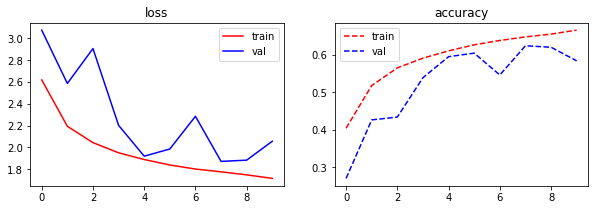

In [32]:
# Q2: training curve visualization
plot_history(history)

student model의 성능이 어떻게 변했는지 확인을 해보세요. 또, hyperparameter를 수정할 때 모델의 성능이 어떻게 변하는지도 확인해봅니다.

## Q3. Attention Transfer를 이용하여 모델 성능 개선시키기 (40 min)

$x_t$, $x_s$를 teacher/student의 feature map 값이라고 할 때, attention transfer의 식은 아래와 같습니다.

\begin{align}
a_t & = \sum_{i=1}^{C} |x_t^{(i)}| \\
a_s & = \sum_{i=1}^{C} |x_s^{(i)}| \\
\mathcal{L}_\text{AT} (x_t, x_s) & = \left\lVert \frac{\text{vec}(a_t)}{\lVert\text{vec}(a_t)\rVert_2} - \frac{\text{vec}(a_s)}{\lVert\text{vec}(a_s)\rVert_2}\right\rVert_2
\end{align}

아래의 함수(링크 참조)를 이용하여, 위의 knowledge distillation loss $\mathcal{L}_\text{AT} (x_t, x_s)$를 구현하세요.
- [`tf.math.abs`](https://www.tensorflow.org/api_docs/python/tf/math/abs) : 절대값 연산 $|\cdot|$ 을 할 때 사용됩니다.
- [`tf.math.reduce_sum`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum) : $\sum_{i=1}^C$ 할 때 사용합니다.
- [`tf.keras.layers.Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) : attention map $a_t$ 혹은 $a_s$ 를 vector로 만들어줄 때 사용합니다.
- [`tf.math.l2_normalize`](https://www.tensorflow.org/api_docs/python/tf/math/l2_normalize) : vector를 normalize할 때 사용합니다.
- [`tf.norm`](https://www.tensorflow.org/api_docs/python/tf/norm) : vector의 norm을 구할 때 사용합니다.
- [`tf.math.reduce_mean`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean) : batch의 모든 sample에 대해서 average를 취할 때 사용합니다.

In [33]:
def attention_transfer(x_t, x_s):
    # Q3: attention transfer 구현
    print(x_t)
    a_t = tf.math.reduce_sum(tf.math.abs(x_t), axis=3)
    a_s = tf.math.reduce_sum(tf.math.abs(x_s), axis=3)
    print(a_s)
    a_t_v = tf.keras.layers.Flatten()(a_t)
    a_s_v = tf.keras.layers.Flatten()(a_s)    
    print(a_s_v)
    #loss = tf.norm( tf.math.l2_normalize(a_t_v, axis=1)-tf.math.l2_normalize(a_s_v, axis=1), axis=1 )
    loss = tf.norm( tf.math.l2_normalize(a_t_v)-tf.math.l2_normalize(a_s_v), axis=1 )
    print(loss)
    loss = tf.math.reduce_mean(loss)
    print(loss)
    return loss

In [34]:
attention_transfer(x1_t, x1_s)

Tensor("activation_1/Relu:0", shape=(?, 32, 32, 16), dtype=float32)
Tensor("Sum_2:0", shape=(?, 32, 32), dtype=float32)
Tensor("flatten_1/Reshape:0", shape=(?, 1024), dtype=float32)
Tensor("norm/Squeeze:0", shape=(?,), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)


<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

이제, CNN을 학습하기 위한 loss function을 정의합니다. 아래에서 `at_weight` 는 attention transfer loss의 비중을 나타냅니다. AT loss는 각 hidden feature map 쌍(e.g., `x1_t`와 `x1_s`)에 대해 추가해주어야 합니다.

In [35]:
def loss_with_at(y_true, y_pred):
    at_weight = 0.1
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # Q3: attention transfer loss 추가
    loss = loss + at_weight * attention_transfer(x1_t, x1_s) + at_weight * attention_transfer(x2_t, x2_s) + at_weight * attention_transfer(x3_t, x3_s)
    #loss = loss + kd_weight * knowledge_distillation(logits_t, logits_s, T)
    return loss

In [36]:
# student model을 초기화해줍니다.
student.load_weights('student_init.h5')
student.compile(optimizer='adam',
                loss=loss_with_at,      # 이 부분이 기존의 compile과 다릅니다.
                metrics=['accuracy'])

Tensor("activation_1/Relu:0", shape=(?, 32, 32, 16), dtype=float32)
Tensor("loss_3/activation_13_loss/Sum_1:0", shape=(?, 32, 32), dtype=float32)
Tensor("loss_3/activation_13_loss/flatten_3/Reshape:0", shape=(?, 1024), dtype=float32)
Tensor("loss_3/activation_13_loss/norm/Squeeze:0", shape=(?,), dtype=float32)
Tensor("loss_3/activation_13_loss/Mean:0", shape=(), dtype=float32)
Tensor("activation_3/Relu:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("loss_3/activation_13_loss/Sum_3:0", shape=(?, 16, 16), dtype=float32)
Tensor("loss_3/activation_13_loss/flatten_5/Reshape:0", shape=(?, 256), dtype=float32)
Tensor("loss_3/activation_13_loss/norm_1/Squeeze:0", shape=(?,), dtype=float32)
Tensor("loss_3/activation_13_loss/Mean_1:0", shape=(), dtype=float32)
Tensor("activation_5/Relu:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("loss_3/activation_13_loss/Sum_5:0", shape=(?, 8, 8), dtype=float32)
Tensor("loss_3/activation_13_loss/flatten_7/Reshape:0", shape=(?, 64), dtype=float32)
Tensor("l

In [37]:
# Q3: train student with attention transfer
history = student.fit_generator(datagen_c10,
                                steps_per_epoch=steps_per_epoch,
                                epochs=num_epochs,
                                validation_data=(x_test_c10, y_test_c10))

Epoch 1/10


W0730 00:34:03.182818 13384 deprecation.py:323] From C:\Users\home0194\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


300/300 [==============================] - 121s 404ms/step - loss: 1.6711 - acc: 0.4039 - val_loss: 2.4593 - val_acc: 0.2288
Epoch 2/10
300/300 [==============================] - 120s 399ms/step - loss: 1.3720 - acc: 0.5076 - val_loss: 1.4087 - val_acc: 0.5003
Epoch 3/10
300/300 [==============================] - 119s 396ms/step - loss: 1.2419 - acc: 0.5565 - val_loss: 1.2968 - val_acc: 0.5303
Epoch 4/10
300/300 [==============================] - 119s 396ms/step - loss: 1.1785 - acc: 0.5829 - val_loss: 1.4536 - val_acc: 0.5123
Epoch 5/10
300/300 [==============================] - 119s 396ms/step - loss: 1.1192 - acc: 0.6018 - val_loss: 1.1358 - val_acc: 0.5990
Epoch 6/10
300/300 [==============================] - 118s 394ms/step - loss: 1.0799 - acc: 0.6206 - val_loss: 1.1010 - val_acc: 0.6050
Epoch 7/10
300/300 [==============================] - 119s 398ms/step - loss: 1.0343 - acc: 0.6363 - val_loss: 1.3089 - val_acc: 0.5463
Epoch 8/10
300/300 [==============================] - 118s 

최대 도달 성능: 60.82%


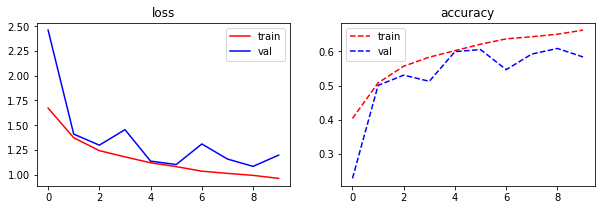

In [38]:
# Q3: training curve visualization
plot_history(history)

## Assignment1. Knowledge Distillation과 Attention Transfer를 같이 사용하여 성능을 개선시키기
- 위의 실습에서 배운 내용을 적극 활용하시면 쉽게 문제를 해결하실 수 있습니다.
- hyperparameter를 조절하여 실험해보세요. 좋은 hyperparameter를 찾은 분께는 가산점을 드릴 예정입니다.
- **아래의 내용에 대해 hankook.lee@kaist.ac.kr 로 제출하시면 됩니다.**
  - 아래의 코드
  - `fit_generator` 결과
  - `plot_history` 결과 (그림 첨부)

In [50]:
def loss_with_kd_and_at(y_true, y_pred):
    # A1: knowledge distillation과 attention transfer loss 추가
    at_weight = 0.1
   
    # Teacher 최대 도달 성능: 71.79%

    # case 1  => 최대 도달 성능: 65.87%
    # kd_weight = 0.5
    # T = 2.0
    
    # case 2 => 최대 도달 성능: 71.10%
    # kd_weight = 0.6
    # T = 2.0
    
    # case 3 -> 최대 도달 성능: 71.42%
    # kd_weight = 0.5
    # T = 2.5
    
    # case 4 => 최대 도달 성능: 73.80%
    kd_weight = 0.6
    T = 2.5
    
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # attention transfer loss 추가
    loss = loss + at_weight * attention_transfer(x1_t, x1_s) + at_weight * attention_transfer(x2_t, x2_s) + at_weight * attention_transfer(x3_t, x3_s)
    loss = loss + kd_weight * knowledge_distillation(logits_t, logits_s, T)
    return loss

In [51]:
# A1: student model을 초기화와 compile하는 부분을 작성합니다.
history = student.fit_generator(datagen_c10,
                                steps_per_epoch=steps_per_epoch,
                                epochs=num_epochs,
                                validation_data=(x_test_c10, y_test_c10))

Epoch 1/10
300/300 [==============================] - 214s 712ms/step - loss: 0.7220 - acc: 0.7513 - val_loss: 0.8313 - val_acc: 0.7201
Epoch 2/10
300/300 [==============================] - 213s 712ms/step - loss: 0.7173 - acc: 0.7517 - val_loss: 0.9780 - val_acc: 0.6710
Epoch 3/10
300/300 [==============================] - 213s 709ms/step - loss: 0.7160 - acc: 0.7524 - val_loss: 0.9467 - val_acc: 0.6936
Epoch 4/10
300/300 [==============================] - 195s 650ms/step - loss: 0.7101 - acc: 0.7536 - val_loss: 0.8654 - val_acc: 0.7029
Epoch 5/10
300/300 [==============================] - 119s 398ms/step - loss: 0.7105 - acc: 0.7551 - val_loss: 0.8147 - val_acc: 0.7191
Epoch 6/10
300/300 [==============================] - 120s 400ms/step - loss: 0.7112 - acc: 0.7540 - val_loss: 0.8742 - val_acc: 0.7076
Epoch 7/10
300/300 [==============================] - 120s 401ms/step - loss: 0.7028 - acc: 0.7555 - val_loss: 0.8551 - val_acc: 0.7171
Epoch 8/10
300/300 [============================

최대 도달 성능: 73.80%


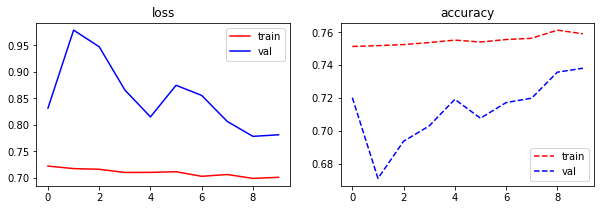

In [52]:
# A1: model을 학습하고, training curve를 확인하여 학습이 잘 되었는지 확인합니다.
plot_history(history)